In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
sales = pd.read_csv("sales_train_evaluation.csv")
prices = pd.read_csv("sell_prices.csv")
cal = pd.read_csv("calendar.csv")

In [16]:
d_cols = [d for d in sales.columns if 'd_' in d] 
X_train = sales[d_cols[:1913]]
X_test = sales[d_cols]

In [5]:
#Performance metrics
#https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

from typing import Union

class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)

In [19]:
#Hyper-parameter tuning i.e trying different values for smoothing parameter
# and selecting the parameter with low MSE

#for alpha = 0.2
pred_1 = []
for i in tqdm(range(len(sales))):
    model = SimpleExpSmoothing(X_train.iloc[i]).fit(smoothing_level=0.2,optimized=False)
    pred_i = model.forecast(28).values
    pred_1.append(pred_i)


100%|██████████| 30490/30490 [04:16<00:00, 118.67it/s]


In [20]:
train_df = sales.iloc[:,:-28]
val_df = sales.iloc[:,-28:]
preds_valid = pd.DataFrame(pred_1,columns = d_cols[-28:])
evaluator = WRMSSEEvaluator(train_df, val_df, cal, prices)
score = evaluator.score(preds_valid)
print("WRMSSE score of valid[1914-1941] data :",score)

100%|██████████| 12/12 [00:22<00:00,  1.85s/it]


WRMSSE score of valid[1914-1941] data : 1.075649882586048


In [21]:
#for alpha = 0.5
pred_2 = []
for i in tqdm(range(len(sales))):
    model = SimpleExpSmoothing( X_train.iloc[i]).fit(smoothing_level=0.5,optimized=False)
    pred_i = model.forecast(28).values
    pred_2.append(pred_i)


100%|██████████| 30490/30490 [04:14<00:00, 119.63it/s]


In [22]:
train_df = sales.iloc[:,:-28]
val_df = sales.iloc[:,-28:]
preds_valid = pd.DataFrame(pred_2,columns = d_cols[-28:])
evaluator = WRMSSEEvaluator(train_df, val_df, cal, prices)
score = evaluator.score(preds_valid)
print("WRMSSE score of valid[1914-1941] data :",score)

100%|██████████| 12/12 [00:16<00:00,  1.36s/it]


WRMSSE score of valid[1914-1941] data : 1.203318330283391


In [23]:
#for alpha = default value selected by model
pred_3 = []
for i in tqdm(range(len(sales))):
    model = SimpleExpSmoothing(X_train.iloc[i]).fit()
    pred_i = model.forecast(28).values
    pred_3.append(pred_i)

100%|██████████| 30490/30490 [05:05<00:00, 99.74it/s] 


In [24]:
preds_valid = pd.DataFrame(pred_3,columns = d_cols[-28:])
evaluator = WRMSSEEvaluator(train_df, val_df, cal, prices)
score = evaluator.score(preds_valid)
print("WRMSSE score of valid[1914-1941] data :",score)

100%|██████████| 12/12 [00:18<00:00,  1.56s/it]


WRMSSE score of valid[1914-1941] data : 1.0753242820195354


In [25]:
#using deafault smoothing value for alpha
pred = []
for i in tqdm(range(len(sales))):
    model_2 = SimpleExpSmoothing(X_test.iloc[i]).fit()
    pred_i = model_2.forecast(28).values
    pred.append(pred_i)

100%|██████████| 30490/30490 [05:07<00:00, 99.02it/s]


In [26]:
pred_3 = np.array(pred_3)
pred = np.array(pred)

In [30]:
sub_df = pd.read_csv('sample_submission.csv')
sub_1 = sub_df.iloc[:30490,:]
sub_2 = sub_df.iloc[30490:,:]

f_cols = [f for f in sub_df.columns if 'F' in f]
for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_3[:,i]
    sub_2[f_cols[i]] = pred[:,i]

In [31]:
sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411,0.992411
1,HOBBIES_1_002_CA_1_validation,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631,0.128631
2,HOBBIES_1_003_CA_1_validation,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011
3,HOBBIES_1_004_CA_1_validation,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204,2.014204
4,HOBBIES_1_005_CA_1_validation,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216,0.694216
60976,FOODS_3_824_WI_3_evaluation,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782,0.239782
60977,FOODS_3_825_WI_3_evaluation,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215,0.871215
60978,FOODS_3_826_WI_3_evaluation,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913,1.323913


In [32]:
sub.to_csv("ses_sub.csv",index = False)

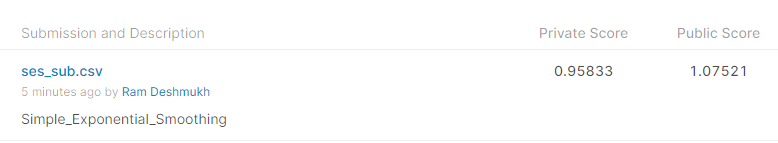